In [1]:
import numpy as np
import pyemma
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pyemma.plots as mplt
import h5py
import MSMRD.trajectories.trajectoryTools as trajectoryTools
from MSMRD.discretization import partitionSphere, plotPartitionedSphere
from MSMRD.visualization import createDensityData
%load_ext Cython

/home/maojrs/miniconda2/lib/python2.7/site-packages/pyemma/__init__.py:91: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.4, you have 2.3.2.
  .format(latest=latest, current=current), category=UserWarning)


In [2]:
%matplotlib inline
#%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (4.0, 4.0)
plt.rc('text', usetex='True')
plt.rc('font', family='serif')

141


/home/maojrs/miniconda2/lib/python2.7/site-packages/MSMRD-0.1-py2.7-linux-x86_64.egg/MSMRD/discretization/spherePartition.py:181: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


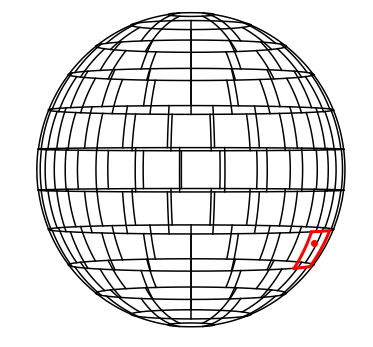

In [3]:
# Testing correct state output mini script (use along with testSpherePrtitionPlot NB)
# Consistent with test
numPartitions = 177
boxSize = 5
innerMSMrad = 2.5
minima = np.array([[-0.9,0.7,0.3] , [-0.1,0.9,0.7],  [0.8,0.8,-0.8],  \
                  [-1.0,-0.3,-0.4], [0.0,0.0,0.0],   [0.9,-0.1,-0.9], \
                  [-0.7,-1.0,-0.3], [0.0,-0.9,0.1],  [0.8,-0.2,0.8]])
regionsPerCollar, phis, thetas = partitionSphere(numPartitions)
discretizer = trajectoryTools.trajDiscretization3DCython(minima, boxSize, innerMSMrad)
discretizer.getSpherePartition(regionsPerCollar, phis, thetas)
coord = np.array([3.4,-2,-2]) # norm larger than innerMSMrad (boxSize/2)
sphereState = discretizer.getStatePy(coord,-1) - (len(minima) - 1)

# Call function to plot state and coordinate in spherical partition
print sphereState
plotPartitionedSphere(numPartitions = numPartitions, plotState=sphereState, coord=coord)

In [4]:
%%time
numfiles = 6
# Load partitions, boxsize and minimas
numPartitions = 322
boxSize = 6
innerMSMrad = 2.5
regionsPerCollar, phis, thetas = partitionSphere(numPartitions)
minima = np.array([[-0.9,0.7,0.3] , [-0.1,0.9,0.7],  [0.8,0.8,-0.8],  \
                  [-1.0,-0.3,-0.4], [0.0,0.0,0.0],   [0.9,-0.1,-0.9], \
                  [-0.7,-1.0,-0.3], [0.0,-0.9,0.1],  [0.8,-0.2,0.8]])

# Extract trajectories from file using asym2Dtraj class
# fname = '../data/asym3D/3DasymTrajs_pBox5_sf2_R4_RT1e7_dt001_si10_' # old data with bug in potential
# fname = '../data/asym3D/3DasymTrajs_pbox5_RT1e7_sf2.0_dt0.001_si10_run_'
fname = '../data/asym3D/3DasymTrajs_pbox6_RT1e7_sf2.0_dt0.001_si10_run_'
dimension = 3
discretizer = trajectoryTools.trajDiscretization3DCython(minima, boxSize,innerMSMrad)
discretizer.getSpherePartition(regionsPerCollar, phis, thetas)
trajs = []
dTrajs = []
#fullDTrajs = []
truncTrajs = []
dTruncTrajs = []
i = 0
samplingInterval = 10 # in the original computation
for number in range(numfiles):
    f = h5py.File(fname + str(number) + '.h5', 'r')
    data = np.array(f['traj'], dtype=float)
    f.close()
    if not np.allclose(data[1:,0]-data[:-1,0], samplingInterval):
        print 'timestep not constant'
    traj = data[:,1:dimension+1]
    #fullDTrajs.append(discretizer.getdTrajs([traj]))
    dTrajs += discretizer.getdTrajs([traj])
    lastTruncTrajs = discretizer.getTruncatedTraj(traj, prepend=True) # Use True for code, false for traj plotting?
    truncTrajs += lastTruncTrajs
    dTruncTrajs += discretizer.getdTrajs(lastTruncTrajs)
    i+=1
    if i % 10 == 0:
        print str(i/float(numfiles) * 100)+'% done'
    # delete memory to avoid overhead
    del data
    del traj
    #trajs.append(traj) # Need to pass to create density data for visit visualization

CPU times: user 2min 10s, sys: 220 ms, total: 2min 10s
Wall time: 2min 10s


95883


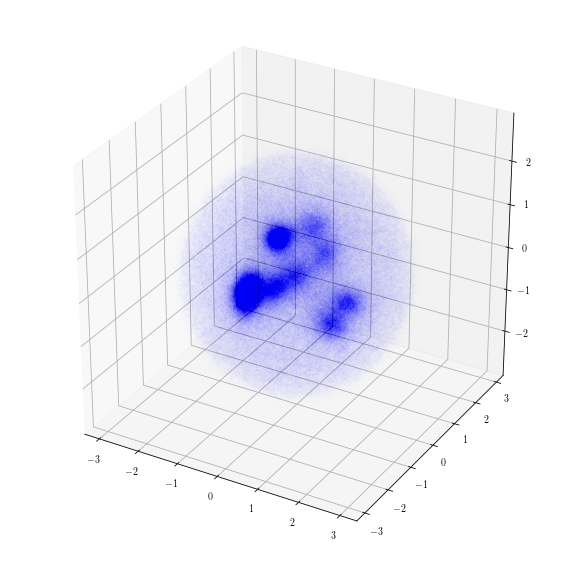

In [5]:
# visualize trunc trajs
def plotTrajs(trajs,numTrajs):
    fig = plt.figure(figsize=[10,10])
    ax = fig.gca(projection='3d') 
    i=0
    print(len(trajs))
    for traj in trajs:
        trajx = []
        trajy = []
        trajz = []
        for i in range(len(traj)):
            trajx.append(traj[i][0])
            trajy.append(traj[i][1])
            trajz.append(traj[i][2])
        #ax.plot(trajx,trajy,trajz,'.')
        ax.plot(trajx,trajy,trajz,'b-', lw=0.0002)
        i += 1
        if i > numTrajs:
            break
            
plotTrajs(truncTrajs,100000)

(array([ -25.,    0.,   25.,   50.,   75.,  100.,  125.,  150.,  175.,  200.]),
 <a list of 10 Text yticklabel objects>)

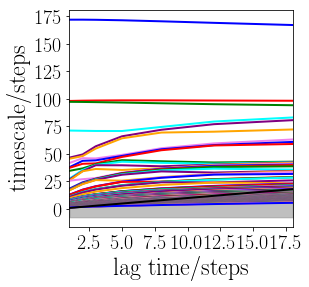

In [6]:
its = pyemma.msm.its(dTrajs, lags = 20)

# Plot implied time scales
mplt.plot_implied_timescales(its, ylog=False, units='steps', linewidth=2, dt=1)
plt.ylabel(r"timescale/steps", fontsize = 24)
plt.xlabel(r"lag time/steps", fontsize = 24)
#plt.xlim(0,900)
#plt.ylim(-100,1700)
#plt.xlim(0,100)
#plt.ylim(100,10000)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [7]:
MSMlag = 10
M = pyemma.msm.estimate_markov_model(dTrajs, lag=MSMlag)

In [8]:
# truncate transition matrix such that only transitions withing the inner states are allowed
Tmatrix= np.copy(M.transition_matrix[:len(minima),:len(minima)])
for i in range(len(minima)):
    Tmatrix[i,:] /= np.sum(Tmatrix[i,:])

In [9]:
# Get exit/entry lookup tables
#%%time
# CALL WITH dTruncTrajs or dTrajs, see function in trajectoryTools.pyx
entryTrajsStart, entryTrajsEnd, entryTimes = discretizer.getLookupTableEntry(dTruncTrajs, truncTrajs)
exitPositions, exitTimes = discretizer.getLookupTableExit(dTruncTrajs, truncTrajs)
transitionTrajs = discretizer.getTransitionTrajs(dTruncTrajs)

In [10]:
# Calculate exit probabilities for each of the inner states
exitProbs = np.zeros(len(minima))
for i in range(len(minima)):
    outgoingTrajs = 0
    for j in range(10): ## WHY 10 and not 9 (len(minima))?
        outgoingTrajs += len(transitionTrajs[i][j])   
    exitProbs[i] = len(transitionTrajs[i][len(minima)])/float(outgoingTrajs)
print exitProbs

[ 0.31467764  0.28777821  0.41743672  0.17297812  0.10563597  0.38493565
  0.16419875  0.15748415  0.4282898 ]


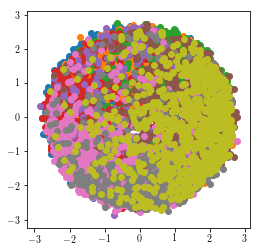

In [11]:
for i in range(9):
    plt.scatter(np.array(exitPositions[i])[:,0], np.array(exitPositions[i])[:,1])
#for i in range(9):
    #print np.sort(exitTimes[i])

In [12]:
# Partition MSM entry trajectories into discrete regions in the sphere 
spherePartitionsForLookUp = 1*numPartitions
regionsPerCollar2, phis2, thetas2 = partitionSphere(spherePartitionsForLookUp)
thetas_coord = np.arctan2(entryTrajsStart[:,1], entryTrajsStart[:,0])
thetas_coord[thetas_coord<0] = thetas_coord[thetas_coord<0] + 2*np.pi
r = np.linalg.norm(entryTrajsStart[:], axis=1)
phis_coords = np.arccos(entryTrajsStart[:,2]/r)
sortedEntryTrajsStart = []
sortedEntryTrajsEnd = []
sortedEntryTimes = []
for i in range(len(regionsPerCollar2)):
    phiIncrement = np.pi/len(regionsPerCollar2)
    idcs_phi = np.where(np.logical_and(phis_coords>i*phiIncrement, phis_coords<= (i+1)*phiIncrement))[0]
    for j in range(regionsPerCollar2[i]):
        thetaIncrement = 2*np.pi/regionsPerCollar2[i]
        idcs_theta = np.where(np.logical_and(thetas_coord>j*thetaIncrement, thetas_coord<= (j+1)*thetaIncrement))[0]
        idcs = np.intersect1d(idcs_phi,idcs_theta)
        sortedEntryTrajsStart.append(entryTrajsStart[idcs])
        sortedEntryTimes.append(entryTimes[idcs])
        sortedEnds = []
        for j in idcs:
            sortedEnds.append(entryTrajsEnd[j])
        sortedEntryTrajsEnd.append(sortedEnds)
        

In [13]:
sortedEntryTimes[144][34]

1

In [14]:
#Prepare data to be extracted to file
#For this we need the position of the cluster centers as well as the information about the angles of the exit states
class truncTrajsModel3D(object):    
    def __init__(self, entryTrajsStart, entryTrajsEnd, entryTimes, exitTrajs, exitTimes, exitProbs, MSMtime, tmatrix, numPartitions):
        self.entryTrajsStart = entryTrajsStart
        self.entryTrajsEnd = entryTrajsEnd
        self.entryTimes = entryTimes
        self.exitTrajs = exitTrajs
        self.exitTimes = exitTimes
        self.exitProbs = exitProbs
        self.tmatrix = tmatrix
        self.MSMtimestep = MSMtime
        self.numPartitions = numPartitions

In [15]:
model = truncTrajsModel3D(sortedEntryTrajsStart, sortedEntryTrajsEnd, sortedEntryTimes, exitPositions, exitTimes, exitProbs, 0.1, Tmatrix, numPartitions)

In [16]:
import pickle
pickle.dump(model, open('../data/models/asym3D/periodicModel_lag10_6files_177partitions.p', 'wa'))

In [ ]:
createDensityData(trajs,filename="test3DdensityData_Sf2_200files")

In [ ]:
MSMradius = 2.
X = np.arange(-MSMradius, MSMradius, 0.05)
Y = np.arange(-MSMradius, MSMradius, 0.05)
Z = np.arange(-MSMradius, MSMradius, 0.05)
Zfull = np.zeros([X.shape[0]-1, Y.shape[0]-1, Z.shape[0]-1])
for trj in trajs:
    hist = np.histogramdd(traj, bins = (X, Y, Z))
    Zfull += hist[0]

In [ ]:
# Not relevant to this notebook (convergence of Sterling approx)
from scipy.misc import factorial
import numpy as np
nn = np.arange(0.1,15,1)
yy1 = np.exp(-nn)*np.power(nn,nn)/factorial(nn)
yy2 = 1/np.sqrt(2*np.pi*nn)
plt.plot(nn,yy1,label='orig')
plt.plot(nn,yy2, label='stirling')
plt.legend() 